# Práctica 2 de Reconocimiento de Patrones:
## Mejoramiento de la Imagen

Integrantes:
 - Diego Fernández Chaparro Plata Javier
 - Vargas Castro Daniel
 - Velázquez Sánchez José Antonio
 
### Objetivos
El alumno:
 - Aprenderá a mejorar la imagen de acuerdo a las modificaciones que se  le realizan original mente
 - Entenderá aumentar las características de contraste, perfilado que apoyen a una mejor medición
 
### Introducción

### Desarrollo

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage import io
import scipy.signal
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.filters import threshold_mean
from collections import deque
import math

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10) # Tamaño de los plots, supuestamente en pulgadas (no poner numeros grandes)

Populating the interactive namespace from numpy and matplotlib


#### A) Revertir contraste y corrección de ruido

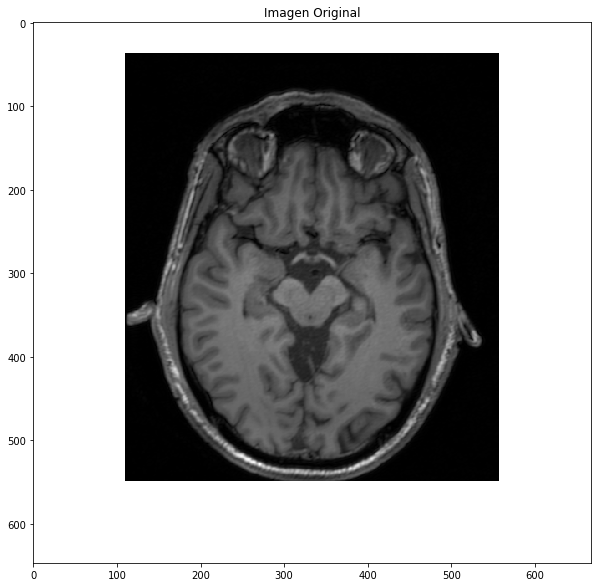

In [3]:
# Imagen Original
original = io.imread("imagenes/midbrain.png", as_gray=True)
plt.imshow(original, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Original")
plt.show()

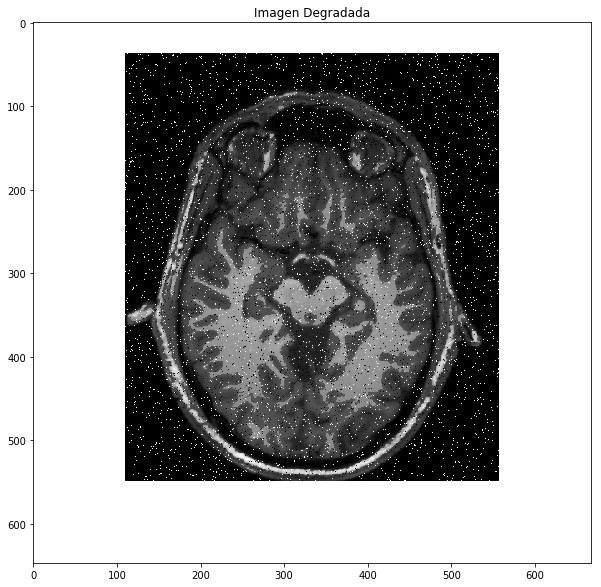

In [4]:
# Imagen Degradada
degraded = io.imread("imagenes/midbrainDegraded.png", as_gray=True)
plt.imshow(degraded, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degradada")
plt.show()

In [5]:
# Función que se aplicó para cambiar el contraste en la imagen original
def change(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx < 0.4:
                changed[i][j] = (5.0/8.0)*origpx
            elif (origpx > 0.4 and origpx < 0.6):
                changed[i][j] = origpx
            else:
                changed[i][j] = (3.0/8.0)*origpx + (3.0/8.0)    
    return changed

In [6]:
# Función para corregir el contraste en la imagen degradada
def revert(modified):
    reverted = np.array(modified, copy=True)
    for i in range(modified.shape[0]):
        for j in range(modified.shape[1]):
            modipx = modified[i][j]
            if modipx < 0.4:
                reverted[i][j] = (8.0/5.0)*modipx
            elif (modipx > 0.4 and modipx < 0.6):
                reverted[i][j] = modipx
            else:
                reverted[i][j] = (8.0/3.0)*modipx - 1.0
    return reverted

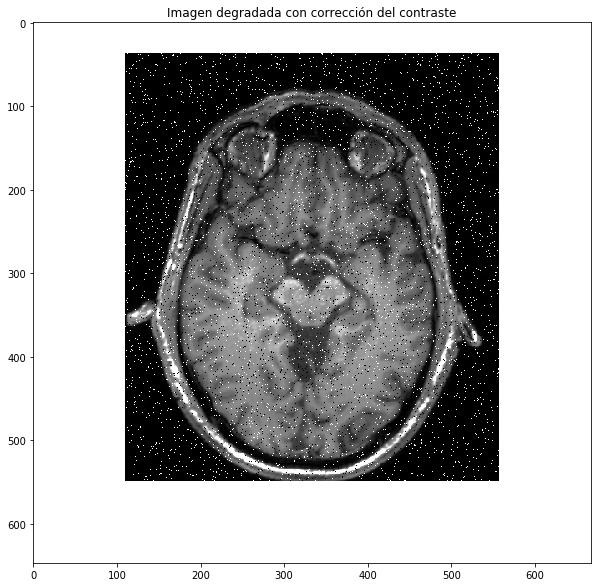

In [7]:
# Corrección del contraste
revertcolors = revert(degraded)
plt.imshow(revertcolors, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen degradada con corrección del contraste")
plt.show()

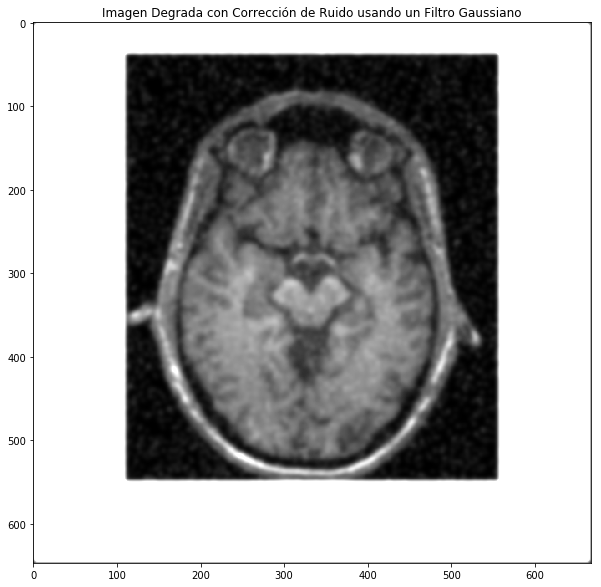

In [8]:
# Corrección del Ruido usando un filtro gaussiano
v = [1,10,45,120,210,252,210,120,45,10,1]
gaussian_filter = np.outer(v, v)
gaussian_filter = gaussian_filter / np.sum(gaussian_filter)

denoised = revertcolors
for _ in range(3):
    denoised = scipy.signal.convolve2d(denoised, gaussian_filter, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degrada con Corrección de Ruido usando un Filtro Gaussiano")
plt.show()

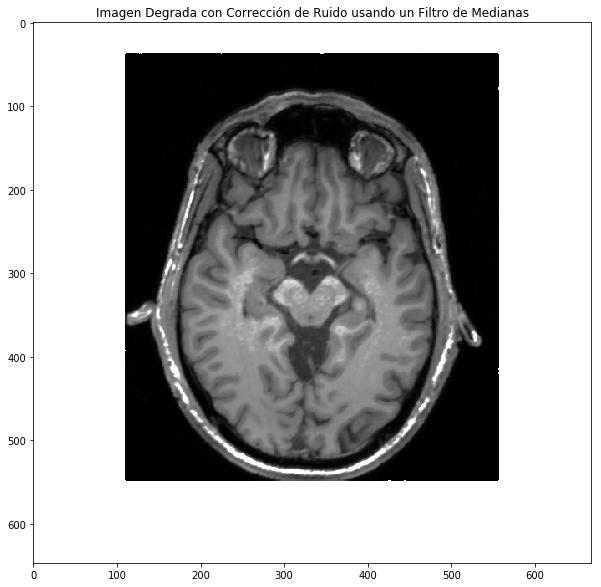

In [9]:
# Correción del ruido usando un filtro de mediana
def median_filter(image, i, j):
    """
    Devuelve la mediana de la vecindad del
    pixel image[i][j].
    """
    max_i = len(image)
    max_j = len(image[0])
    
    move = [-1, 0, 1]
    array = []
    for m in move:
        for n in move:
            if 0 <= i + m < max_i and 0 <= j + n < max_j:
                array.append(image[i + m][j + n])
    
    return np.median(array)

denoised_median = np.zeros(revertcolors.shape)
for i in range(len(revertcolors)):
    for j in range(len(revertcolors[0])):
        # Se calcula la mediana de la vecindad de cada pixel
        denoised_median[i][j] = median_filter(revertcolors, i, j)
        
plt.imshow(denoised_median, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degrada con Corrección de Ruido usando un Filtro de Medianas")
plt.show()

Como se puede observar, el resultado de usar el filtro de medianas es mucho mejor que usar el filtro gaussiano. Esto sucede ya que el filtro de medianas es particularmente útil con el ruido de tipo "sal y pimienta".

#### B) Comparación con imagen perfilada

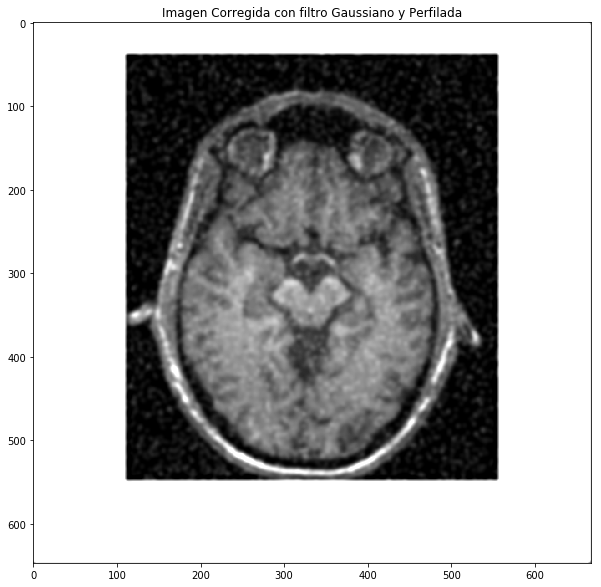

In [10]:
# Filtro de perfilado sobre imagen corregida con filtro gaussiano
identity_filter = np.zeros((11,11))
identity_filter[5][5] = 1

k = 3
profiling_filter = identity_filter + k*(identity_filter - gaussian_filter)

profiled = scipy.signal.convolve2d(denoised, profiling_filter, "same")
plt.imshow(profiled, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Corregida con filtro Gaussiano y Perfilada")
plt.show()

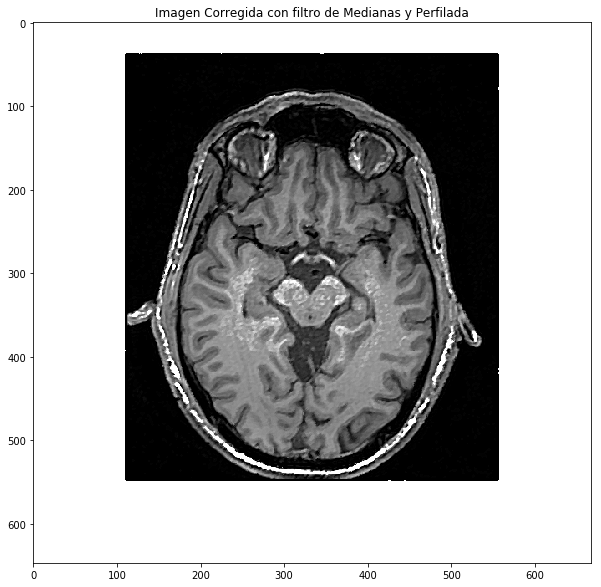

In [11]:
# Filtro de perfilado sobre imagen corregida con filtro de medianas
identity_filter = np.zeros((11,11))
identity_filter[5][5] = 1

k = 3
profiling_filter = identity_filter + k*(identity_filter - gaussian_filter)

profiled = scipy.signal.convolve2d(denoised_median, profiling_filter, "same")
plt.imshow(profiled, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Corregida con filtro de Medianas y Perfilada")
plt.show()

Como era de esperarse, el filtro de perfilado realza los bordes. Sin embargo, en la imagen que fue tratada previamente con el filtro gaussiano, el filtro de perfilado hace que la calidad empeore, ya que no solo realza los bordes de la imagen, sino también los del ruido.

#### C) Clasificación del mesencéfalo

##### Método A) Clasificadores Supervisados: Regresión Lineal y Random Forests
Primero probamos con 2 clasificadores supervisados: Regresión Lineal y Random Forests. Para ello fue necesario hacer una máscara de bits manualmente marcando con "1" la zona donde se encuentra el mesencéfalo y con "0" donde no. Esta máscara la hicimos en GIMP y la importamos al notebook.

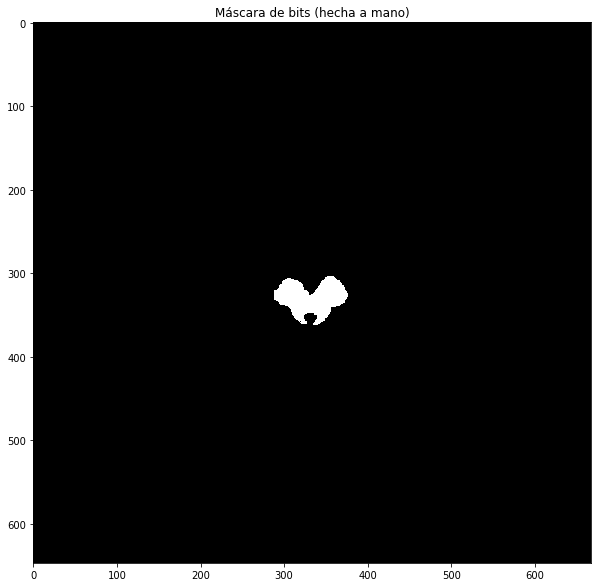

In [12]:
mask = io.imread("imagenes/mask.bmp")
plt.imshow(mask, cmap='gray', vmin = 0, vmax = 1)
plt.title("Máscara de bits (hecha a mano)")
plt.show()

Para crear el conjunto de datos de entrenamiento, tomamos a cada pixel y formamos un vector con el pixel y su vecindad. Asignamos como etiqueta el valor correspondiente del pixel en la máscara de bits.

In [13]:
def get_neighboors(image, i, j):
    max_i = len(image)
    max_j = len(image[0])
    
    move = [-1, 0, 1]
    neighboors = []
    for m in move:
        for n in move:
            if 0 <= i + m < max_i and 0 <= j + n < max_j:
                neighboors.append(image[i + m][j + n])
            else:
                neighboors.append(-1)
                
    return neighboors

In [14]:
data_X = []
data_Y = []

for i in range(denoised_median.shape[0]):
    for j in range(denoised_median.shape[1]):
        data_X.append(get_neighboors(denoised_median, i, j))
        data_Y.append(1 if mask[i][j] > 0 else 0)

A continuación, se mostrarán los resultados de usar un clasificador de regresión logística y después el de random forests. Como se verá el de regresión logística clasifica todo como "0", lo cual no es bueno para nuestro objetivo, pero igualmente le permite tener un 99.29% de exactitud en sus predicciones, ya que la mayor parte de la imagen sí debería ir etiquetada con "0". Por su parte, el clasificador de Random Forests alcanza una exactitud de 99.99%, y sí etiqueta suficientemente bien la región del mesencéfalo.

/home/antoniovs/Escolar/Sem09/patrones/environment/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


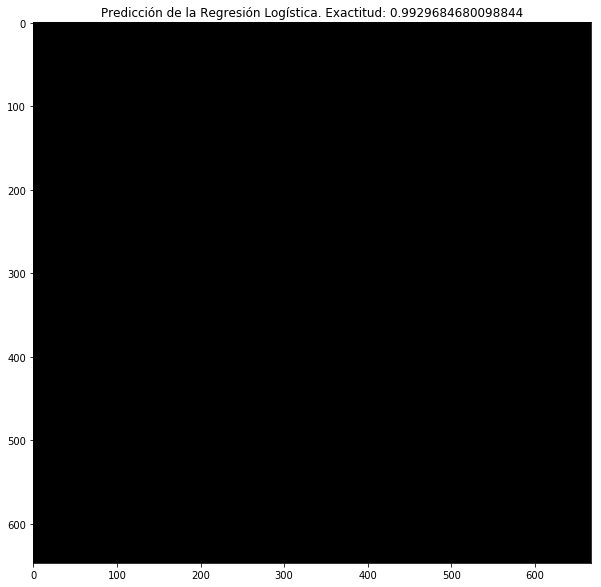

In [15]:
# Probando con Regresión Logística
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(data_X, data_Y)

lr_pred = np.reshape(lr.predict(data_X),denoised_median.shape)
plt.imshow(lr_pred, cmap='gray', vmin = 0, vmax = 1)
plt.title("Predicción de la Regresión Logística. Exactitud: {}".format(lr.score(data_X, data_Y)))
plt.show()

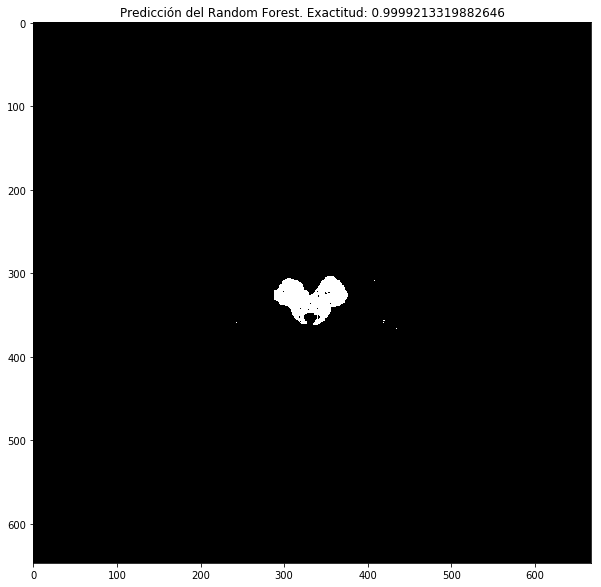

In [16]:
# Probando con Random Forests
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(data_X, data_Y)

rfc_pred = np.reshape(rfc.predict(data_X),denoised_median.shape)
plt.imshow(rfc_pred, cmap='gray', vmin = 0, vmax = 1)
plt.title("Predicción del Random Forest. Exactitud: {}".format(rfc.score(data_X, data_Y)))
plt.show()

##### Método B) Utilizando Region Growing
Para mejorar la clasificación del mesencéfalo utilizamos una técnica de segmentación llamada "Region Growing", con la cual escogemos un pixel de la imagen, y a partir de ahí el algoritmo crece una región a la cual corresponde dicho pixel. En nuestro caso, simplemente escogemos un punto del mesencéfalo. Como se verá, los resultados obtenidos son mejores que los alcanzados con los clasificadores ya mostrados. Además, esta técnica tiene la ventaja de que no es necesario tener un conjunto de datos de entrenamiento, ni ninguna especie de etiquetado manual.

Para poder aplicar esta técnica, es necesario modificar los valores de intensidad de la imagen para que exista mayor contraste entre regiones diferentes.

In [17]:
def mychange(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx > 0.4:
                changed[i][j] = 1.5*origpx
            else:
                changed[i][j] = 0.666*origpx    
    return changed

In [18]:
def neighbours(pixel):
    neighs = []
    xp1 = pixel.copy()
    xp1[1] = xp1[1] + 1
    neighs.append(xp1)
    xp2 = pixel.copy()
    xp2[0] = xp2[0]+1
    xp2[1] = xp2[1]+1
    neighs.append(xp2)
    
    xp3 = pixel.copy()
    xp3[0] = xp3[0]+1
    neighs.append(xp3)
    
    xp4 = pixel.copy()
    xp4[0] = xp4[0]+1
    xp4[1] = xp4[1]-1
    neighs.append(xp4)
    
    xp5 = pixel.copy()
    xp5[1] = xp5[1]-1
    neighs.append(xp5)
    
    xp6 = pixel.copy()
    xp6[0] = xp6[0]-1
    xp6[1] = xp6[1]-1
    neighs.append(xp6)
    
    xp7 = pixel.copy()
    xp7[0] = xp7[0]-1
    neighs.append(xp7)
    
    xp8 = pixel.copy()
    xp8[0] = xp8[0]-1
    xp8[1] = xp8[1]+1
    neighs.append(xp8)
    return neighs

In [19]:
def distneighs(pixel, image):
    pixval = image[pixel[0], pixel[1]]
    neighs = neighbours(pixel)
    #print("sus vecinos son: ", neighs)
    distance = 0.0
    for elem in neighs:
        elemval = image[elem[0], elem[1]]
        distance += (pixval-elemval)**2
    return math.sqrt(distance)

In [20]:
def reggrow(image, seedpix, threshold):
    new_image = np.array(image, copy=True)
    pixset = set()
    qu = deque([])
    qu.append(seedpix)
    while qu:
        act = qu.pop()
        distance = distneighs(act, denoised)
        if(distance < threshold):
            new_image[act[0], act[1]] = 1
            pixset.add(tuple(act))
            for elem in neighbours(act):
                if tuple(elem) not in pixset:
                    qu.append(elem)
    clean_image = np.array(new_image, copy=True)
    for i in range(clean_image.shape[0]):
        for j in range(clean_image.shape[1]):
            if(clean_image[i][j] != 1):
                clean_image[i][j] = 0
    return clean_image

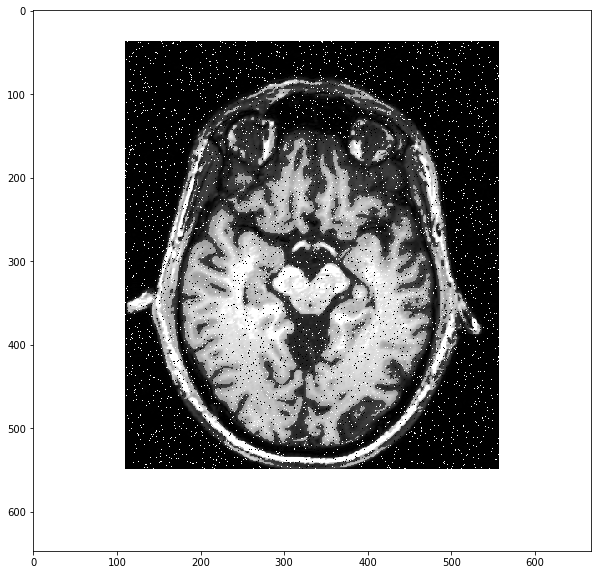

In [21]:
mychanged = mychange(revertcolors)
plt.imshow(mychanged, cmap='gray', vmin = 0, vmax = 1)
plt.show()

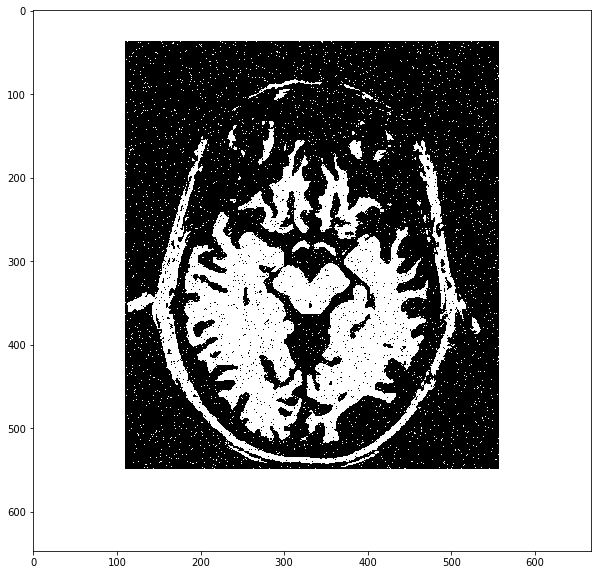

In [22]:
threshimage = mychanged > 0.65
plt.imshow(threshimage, cmap='gray', vmin = 0, vmax = 1)
plt.show()

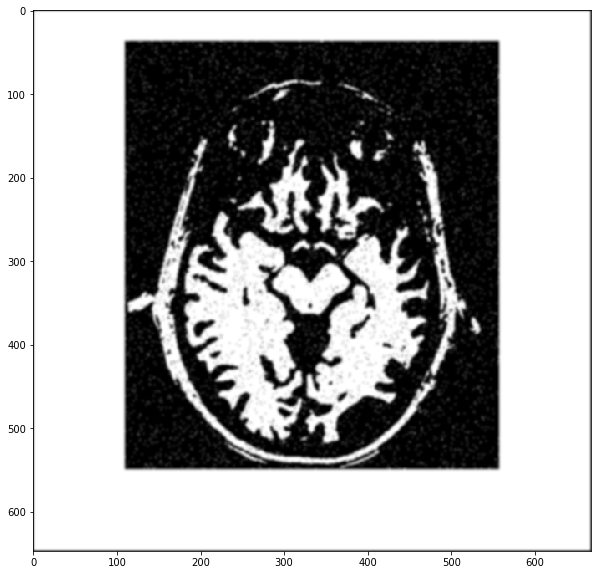

In [23]:
blur_kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])/9.0;
denoised = np.array(threshimage, copy=True)
for i in range(3):
    denoised = scipy.signal.convolve2d(denoised, blur_kernel, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.show()

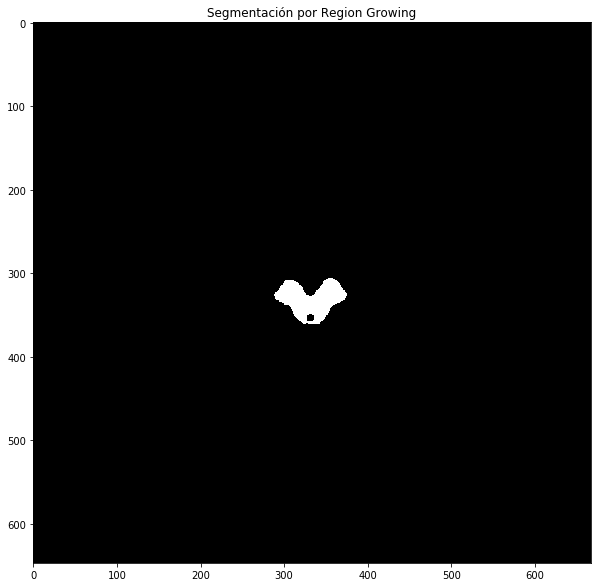

In [24]:
newimage = reggrow(denoised, [327,339], 0.2)
plt.imshow(newimage, cmap='gray', vmin = 0, vmax = 1)
plt.title("Segmentación por Region Growing")
plt.show()

#### D) Mediciones

In [25]:
def mediciones(imagen_binaria, tam_pixel):
    """
    Dada una imagen binaria de un mesencéfalo,
    y el tamaño de sus pixeles en milimetros,
    devuelve la medida longitudinal y
    transversal en milimetros y el area en
    milimetros cuadrados.
    
    :imagen_binaria: arreglo con 0's y 1's
    :tam_pixel: float
    :return tuple[float] (longitudinal, transversal, area)
    """
    
    count = max_x = max_y = 0
    min_x = len(imagen_binaria[0])
    min_y = len(imagen_binaria)
    
    for i, row in enumerate(imagen_binaria):
        for j, pixel in enumerate(row):
            if pixel == 1:
                if i < min_y:
                    min_y = i
                if i > max_y:
                    max_y = i
                if j < min_x:
                    min_x = j
                if j > max_x:
                    max_x = j
                count += 1
    
    if count == 0:
        return (0, 0, 0)
    
    transversal = (max_x - min_x)*tam_pixel
    longitudinal = (max_y - min_y)*tam_pixel
    area = count * tam_pixel * tam_pixel

    return (transversal, longitudinal, area)

In [26]:
print("Transversal: {0}mm, Logitudinal: {1}mm, Area: {2:.2f}mm2".format(*mediciones(newimage, .4)))

Transversal: 34.4mm, Logitudinal: 21.6mm, Area: 432.64mm2


### Conclusiones
- Gracias a esta práctica pudimos reafirmar nuestros conocimientos sobre filtros de procesamiento de imágenes. Particularmene los filtros gaussiano, el filtro identidad, el filtro de Unsharp Mask y el filtro de medianas.
- Observamos que para remover ruido de tipo "sal y pimienta" el filtro de medianas resulta mucho mejor que el filtro gaussiano.
- Pudimos corroborar el efecto del filtro de perfilado Unsharp Mask, el cual no solo realza los bordes de la imagen, pero también los bordes del ruido.
- Observamos que la técnica de Region Growing tuvo resultados excelentes para el trabajo que realizamos, incluso mejores que los que obtuvimos con los clasificadores de regresión lineal y de random forest.

### Fuentes